#Assembly Bias

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

##Load Simulation

In [4]:
#load dark matter simulation
from halotools import sim_manager
from astropy.cosmology import FlatLambdaCDM

#load halo catalogue to populate for mocks
simname = 'bolshoi_250'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.0, dz_tol=0.001,
                                        version_name='custom', halo_finder='Rockstar')
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #bolshoi cosmology

print(halocat.halo_table.dtype.names)
print("number of (sub-)haloes: ", len(halocat.halo_table))

('halo_upid', 'halo_first_acc_mvir', 'halo_acc_scale', 'halo_rvir', 'halo_vpeak', 'halo_macc', 'halo_first_acc_scale', 'halo_mpeak', 'halo_half_mass_scale', 'halo_mvir', 'halo_T/|U|', 'halo_vmax_at_mpeak', 'halo_pid', 'halo_y', 'halo_x', 'halo_z', 'halo_m200b', 'halo_m200c', 'halo_first_acc_vmax', 'halo_mpeak_scale', 'halo_vmax', 'halo_vacc', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo')
number of (sub-)haloes:  6161686


##Load Supplementary Simulation Data

In [5]:
#load additional halo properties
from astropy.table import Table

filepath = '/Volumes/burt/bam_data/'
add_halo_props = Table.read(filepath + "bolshoi_additional_halo_properties.hdf5", path='data')

print(add_halo_props.dtype.names)
print("number of (sub-)haloes: ", len(add_halo_props))

#fix errant halo
mask_1 = (halocat.halo_table['halo_id']==3064140296)
mask_2 = (halocat.halo_table['halo_mvir'] == halocat.halo_table['halo_mvir'][mask_1])
add_halo_props[mask_1] = add_halo_props[mask_2][0]

#load density information
filepath = '/Volumes/burt/bam_data/'
p = Table.read(filepath + "bolshoi_local_density_prime_acc_scale_2.hdf5", path='data')

add_halo_props['p'] = p['p']

('halo_id', 'halo_mpeak', 'halo_mpeak_scale', 'halo_mpeak_prime', 'halo_mpeak_prime_scale', 'halo_0.1_mpeak_scale', 'halo_0.2_mpeak_scale', 'halo_0.3_mpeak_scale', 'halo_0.4_mpeak_scale', 'halo_0.5_mpeak_scale', 'halo_0.6_mpeak_scale', 'halo_0.7_mpeak_scale', 'halo_0.8_mpeak_scale', 'halo_0.9_mpeak_scale', 'halo_0.1_mpeak_prime_scale', 'halo_0.2_mpeak_prime_scale', 'halo_0.3_mpeak_prime_scale', 'halo_0.4_mpeak_prime_scale', 'halo_0.5_mpeak_prime_scale', 'halo_0.6_mpeak_prime_scale', 'halo_0.7_mpeak_prime_scale', 'halo_0.8_mpeak_prime_scale', 'halo_0.9_mpeak_prime_scale', 'halo_acc_scale_1', 'halo_acc_scale_2', 'halo_acc_scale_3', 'halo_acc_scale_4', 'halo_acc_scale_5', 'halo_acc_scale_6', 'halo_acc_scale_7', 'halo_acc_scale_8', 'halo_acc_scale_9', 'halo_acc_scale_10', 'halo_ejt_scale_1', 'halo_ejt_scale_2', 'halo_ejt_scale_3', 'halo_ejt_scale_4', 'halo_ejt_scale_5', 'halo_ejt_scale_6', 'halo_ejt_scale_7', 'halo_ejt_scale_8', 'halo_ejt_scale_9', 'halo_ejt_scale_10', 'halo_last_acc_scale

In [6]:
halocat.halo_table['halo_mpeak'] = add_halo_props['halo_mpeak']
halocat.halo_table['halo_acc_scale'] = add_halo_props['halo_prime_acc_scale_2']

##Define CAM Model #1

Start with a model that does not model evolution in SMHM. 

In [8]:
from halotools.empirical_models import SubhaloModelFactory

#define galaxy selection
def galaxy_selection_func(table):
    mask = (table['stellar_mass'] >= 10**9.5) & (table['stellar_mass'] < np.inf)
    return mask

###Scatter in SMHM

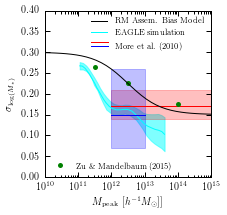

In [11]:
scatter_abscissa  = np.arange(9,17,0.15)

from scipy.stats import norm
scatter_ordinates = norm.cdf(scatter_abscissa[::-1], loc=13.5, scale=1.0)*0.15 + 0.15
scatter_abscissa = 10**scatter_abscissa

#define model for scatter
def f_sigma(m, m0=12.5, k=2.0, sigma0=0.15, sigma1=0.3):
    x = np.log10(m)
    return (sigma1-sigma0)/(1.0+np.exp(1.0*k*(x-m0))) + sigma0
    
#literature measurements of the scatter
#EAGLE
m1 = np.array([13.5985, 13.5190, 13.4198,13.3166,13.2054,13.0863,12.9871,
               12.9036,12.8043,12.7169,12.6177,12.5025,12.3835,12.2922,
               12.1494,12.0184,11.9350,11.8396,11.7761,11.7085,11.6449,
               11.5614,11.5018,11.4144,11.3468,11.2792,11.2117,11.1283,11.0529])
s1 = np.array([0.102731,0.109166,0.112370,0.114498,0.118238,0.122513,
               0.128406,0.135377,0.143958,0.151466,0.158434,0.162173,
               0.162685,0.161590,0.161560,0.165295,0.170116,0.178697,
               0.185673,0.194798,0.203924,0.215197,0.225399,0.237208,
               0.246871,0.254384,0.261358,0.266717,0.267238])
m11 = np.array([13.6020,13.5067,13.4114,13.3003,13.1892,13.0582,12.9510,
                12.8438,12.7446,12.6254,12.5262,12.4111,12.3119,12.2127,
                12.0738,11.9706,11.8514,11.7640,11.6646,11.5811,11.4818,
                11.4102,11.3268,11.2473,11.1480,11.0488])
s11 = np.array([0.143592,0.148948,0.151616,0.151054,0.151030,0.151540,
                0.154743,0.161171,0.165989,0.170802,0.173469,0.173981,
                0.172347,0.172864,0.176059,0.181951,0.192141,0.201262,
                0.213606,0.226491,0.239911,0.249035,0.259770,0.267818,
                0.274248,0.276377])
m12 = np.array([13.6029,13.5036,13.3845,13.2773,13.1463,13.0191,12.8999,
                12.8006,12.7131,12.6337,12.5384,12.4550,12.3400,12.2011,
                12.0979,11.9629,11.8597,11.7405,11.6252,11.5258,11.4463,
                11.3588,11.2555,11.1761,11.0927,11.0570])
s12 = np.array([0.0618715,0.0693771,0.0741902,0.0800812,0.0875799,0.0993806,
                0.114409,0.126753,0.137487,0.144459,0.149815,0.152485,
                0.150848,0.149205,0.149183,0.154530,0.162035,0.175450,
                0.192630,0.208738,0.221086,0.236659,0.247389,0.254899,
                0.258645,0.258637])

#More
m3r = np.array([12,15])
s3r = np.array([0.17,0.17])
s3r_upper =  s3r + 0.04
s3r_lower =  s3r - 0.03
m3b = np.array([12,13])
s3b = np.array([0.15,0.15])
s3b_upper =  s3b + 0.11
s3b_lower =  s3b - 0.08

#Zu and Mandlebaum
m4 = np.array([11.5,12.5,14.0])
s4 = np.array([10.18-9.65,10.8-10.35,11.389-11.04])/2.0

#plot model and literature values
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.fill_between(10**m11, s12, s11, color='cyan', alpha=0.5)
p1, = plt.plot(10**m1, s1, color='cyan')
plt.fill_between(10**m3r, s3r_lower, s3r_upper, color='red', alpha=0.25)
p3a, = plt.plot(10**m3r, s3r, color='red')
plt.fill_between(10**m3b, s3b_lower, s3b_upper, color='blue', alpha=0.25)
p3b, = plt.plot(10**m3b, s3b, color='blue')
p2, = plt.plot(10**m4, s4, 'o', color='green', mec='none', ms=5)
p0, = plt.plot(scatter_abscissa, f_sigma(scatter_abscissa), '-', color='black')
plt.xscale('log')
plt.xlim([10**10,10**15])
plt.ylim([0,0.4])
plt.ylabel(r'$\sigma_{\log(M_*)}$')
plt.xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]]$')

#add legends
first_legend = plt.legend([p0,p1],['RM Assem. Bias Model','EAGLE simulation'],
                          frameon = False, fontsize=8, loc='upper right',
                          numpoints=1, handletextpad=1)
ax = plt.gca().add_artist(first_legend)
plt.legend([p2],['Zu \& Mandelbaum (2015)'],
           frameon = False, fontsize=8, loc='lower left',
           numpoints=1, handletextpad=1)
plt.plot([2.5*10.0**11, 10.0**11.9],[0.325, 0.325], '-', color='red')
plt.plot([2.5*10.0**11, 10.0**11.9],[0.315, 0.315], '-', color='blue')
plt.text(10**12.1, 0.31, 'More et al. (2010)', fontsize=8)
plt.show()

filepath = './figures/'
filename = 'scatter_model'
fig.savefig(filepath+filename+'.pdf', dpi=300)

scatter_ordinates = f_sigma(scatter_abscissa)

###Strength of Assembly Bias

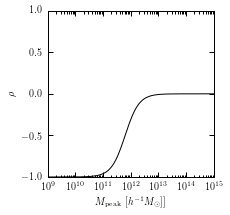

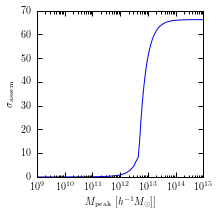

In [13]:
from scipy.interpolate import interp1d

#function to prefrom conversion between sigma_ssfr and rho_ssfr
from scipy.stats import spearmanr
from beyond_age_matching.make_mocks.model_components import scatter_ranks
def translate_rho_param(sigma):
        #create test array
        N = 10**5
        x = np.linspace(0,1,N)
        
        #scatter test array
        xx = scatter_ranks(x,np.fabs(sigma))
        
        #calculate correlation strength
        if sigma < 0.0: xx = xx[::-1]
        rho = spearmanr(x,xx)[0]
        
        return rho

#build function to convert from rho to sigma
sigmas = np.logspace(-2,1,100)
rhos = np.zeros(len(sigmas))
err = np.zeros(len(sigmas))
temp = np.zeros(25)
N = 10**4
x = np.linspace(0,1,N)
for i,sigma in enumerate(sigmas):
    for k in range(0,25):
        xx = scatter_ranks(x,np.fabs(sigma))
        if sigma < 0.0: xx = xx[::-1]
        temp[k] = spearmanr(x,xx)[0]
    rhos[i] = np.mean(temp)
    err[i] = np.std(temp)
f = interp1d(np.sort(rhos)[::-1], sigmas, fill_value = 'extrapolate')
ff = lambda x: f(np.fabs(x))

#define model for assembly bias strength
def f_rho(m, m0=11.8, k=4.0, sigma0=0.0, sigma1=-1.0):
    x = np.log10(m)
    return (sigma1-sigma0)/(1.0+np.exp(1.0*k*(x-m0))) + sigma0    

assem_scatter_abscissa  = np.arange(9,17,0.05)
assem_scatter_abscissa = 10**assem_scatter_abscissa

#plot model for rho
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(assem_scatter_abscissa, f_rho(assem_scatter_abscissa), '-', color='black')
plt.xscale('log')
plt.xlim([10**9,10**15])
plt.ylim([-1.0,1.0])
plt.ylabel(r'$\rho$')
plt.xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]]$')
plt.show()

#plot resulting model for sigma
assem_scatter_ordinates = f_rho(assem_scatter_abscissa)
assem_rho_ordinates = assem_scatter_ordinates
assem_scatter_ordinates = ff(assem_scatter_ordinates)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(assem_scatter_abscissa, assem_scatter_ordinates)
plt.xscale('log')
plt.xlim([10**9,10**15])
plt.ylabel(r'$\sigma_{\rm assem}$')
plt.xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]]$')
plt.show()

##RM model w/ assembly bias

In [14]:
from beyond_age_matching.make_mocks.model_components import SMHM_CAM

scatter_ordinates_prime = scatter_ordinates*0.0 + 0.15

#build model
prim_haloprop_key = 'halo_mpeak'
sec_haloprop_key = 'halo_half_mass_scale'
mstar_model = SMHM_CAM(prim_haloprop_key = prim_haloprop_key,
                       sec_haloprop_key = sec_haloprop_key, redshift=0.0,
                       scatter_abscissa = scatter_abscissa,
                       scatter_ordinates = scatter_ordinates,
                       assem_scatter_abscissa = assem_scatter_abscissa,
                       assem_scatter_ordinates = assem_scatter_ordinates)
#10.9383       9.99479418   5.           0.1541787 
mstar_model.param_dict['x0'] = 10.9383
mstar_model.param_dict['y0'] =  9.75337807
mstar_model.param_dict['alpha'] = 5
mstar_model.param_dict['gamma'] = 0.28
composite_model_a = SubhaloModelFactory(stellar_mass = mstar_model,
                                        galaxy_selection_func = galaxy_selection_func)

#populate simulation
composite_model_a.populate_mock(halocat = halocat)
mock_a = composite_model_a.mock.galaxy_table

print("number of galaxies in mock: ", len(mock_a))
f_sat = float(np.sum(mock_a['halo_upid']!=-1))/len(mock_a)
print("satellite fraction: ", f_sat)

number of galaxies in mock:  298927
satellite fraction:  0.264971046443


##RM model w/o assembly bias

In [15]:
from beyond_age_matching.make_mocks.model_components import SMHM_CAM

scatter_ordinates_prime = scatter_ordinates*0.0 + 0.15
assem_scatter_ordinates_prime = assem_scatter_ordinates*0.0 + 100.0

#build model
prim_haloprop_key = 'halo_mpeak'
sec_haloprop_key = 'halo_half_mass_scale'
mstar_model = SMHM_CAM(prim_haloprop_key = prim_haloprop_key,
                       sec_haloprop_key = sec_haloprop_key, redshift=0.0,
                       scatter_abscissa = scatter_abscissa,
                       scatter_ordinates = scatter_ordinates*0.0,
                       assem_scatter_abscissa = assem_scatter_abscissa,
                       assem_scatter_ordinates = assem_scatter_ordinates_prime)
#10.9383       9.75337807   5.           0.33134794
#mstar_model.param_dict['x0'] = 10.9383
#mstar_model.param_dict['y0'] =  9.75337807
#mstar_model.param_dict['alpha'] = 5
#mstar_model.param_dict['gamma'] = 0.28
composite_model_b = SubhaloModelFactory(stellar_mass = mstar_model,
                                        galaxy_selection_func = galaxy_selection_func)

#populate simulation
composite_model_b.populate_mock(halocat = halocat)
mock_b = composite_model_b.mock.galaxy_table

print("number of galaxies in mock: ", len(mock_b))
f_sat = float(np.sum(mock_b['halo_upid']!=-1))/len(mock_b)
print("satellite fraction: ", f_sat)

number of galaxies in mock:  300447
satellite fraction:  0.214387229694


##stellar mass function

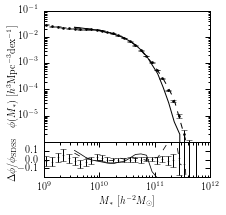

In [16]:
def stellar_mass_func(mock):
    """
    caclulate stellar mass function
    """
    
    #stellar mass function
    bins = np.arange(9.5,12,0.1)
    bins = 10.0**bins
    bin_centers = (bins[:-1]+bins[1:])/2.0
    counts = np.histogram(mock['stellar_mass'],bins=bins)[0]
    dndm = counts/(halocat.Lbox[0]**3)/0.1

    return dndm, bin_centers

dndm_a, bin_centers = stellar_mass_func(mock_a)
dndm_b, bin_centers = stellar_mass_func(mock_b)

#load sdss results
from lss_observations.stellar_mass_functions import LiWhite_2009_phi
from lss_observations.stellar_mass_functions import Baldry_2011_phi
from lss_observations.stellar_mass_functions import Yang_2012_phi
sdss_phi = LiWhite_2009_phi()
#sdss_phi = Baldry_2011_phi()
#sdss_phi = Yang_2012_phi()

sdss_m = np.arange(9,12,0.1)
sdss_m = 10.0**sdss_m 
sdss_dndm = sdss_phi(sdss_m)
sdss_err = sdss_dndm * 0.05

sdss_dndm = sdss_phi.data_table['phi']
sdss_err = sdss_phi.data_table['err']
sdss_m = sdss_phi.data_table['bin_center']

#plot stellar mass function
fig = plt.figure(figsize=(3.3,3.3))

#upper panel
rect = 0.2,0.35,0.7,0.55
ax = fig.add_axes(rect)
p0 = ax.errorbar(sdss_m, sdss_dndm, yerr=sdss_err, fmt='o', color='black', ms=2)
p1, = ax.plot(bin_centers, dndm_a, '-', color='black')
p2, = ax.plot(bin_centers, dndm_b, '--', color='black')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\phi(M_{*})~[h^{3}{\rm Mpc}^{-3}{\rm dex}^{-1}]$', labelpad=-1)
ax.set_xlim([10**9,10**12])
ax.set_ylim([10**-6,10**-1])
ax.set_yticks([10**-5,10**-4,10**-3,10**-2,10**-1])
ax.xaxis.set_visible(False)

#lower panel
rect = 0.2,0.2,0.7,0.15
ax = fig.add_axes(rect)
ax.plot(bin_centers, (dndm_a-sdss_phi(bin_centers))/sdss_phi(bin_centers),'-', color='black', lw=0.75)
ax.plot(bin_centers, (dndm_b-sdss_phi(bin_centers))/sdss_phi(bin_centers),'--', color='black', lw=0.75)
ax.errorbar(sdss_m,  (sdss_dndm-sdss_phi(sdss_m))/sdss_phi(sdss_m), yerr=(sdss_err)/sdss_phi(sdss_m), fmt='o', color='black', ms=1, lw=1)
ax.set_ylabel(r'$\Delta\phi/\phi_{\rm SDSS}$', labelpad=-2)
ax.set_xlabel(r'$M_{*} ~[h^{-2}M_{\odot}]$')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([10**(-0.2),10**(0.2)])
ax.set_ylim([-0.2,0.2])
ax.set_yticks([-0.1,0.0,0.1])
ax.set_xlim([10**9,10**12])

plt.show()

##The SMHM relation

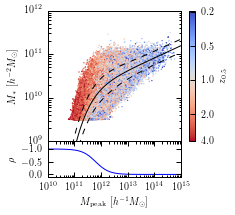

In [35]:
from scipy.interpolate import interp1d
x = np.log10(scatter_abscissa)
y = scatter_ordinates
f = interp1d(x,y)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

#upper panel
rect = 0.2,0.35,0.7,0.55
ax = fig.add_axes(rect)
plt.scatter(mock_a['halo_mpeak'], mock_a['stellar_mass'], c = mock_a['halo_half_mass_scale'],
            lw=0, s=2, vmin=0.2, vmax=0.84, cmap='coolwarm_r', rasterized=True)
msample = np.logspace(10,15,100)
log_mean = np.log10(composite_model_a.mean_stellar_mass(prim_haloprop = msample, halo_acc_scale=1.0))
log_sigma = f(np.log10(msample))
ax.plot(msample, 10**(log_mean+log_sigma), '--', color='black')
ax.plot(msample, 10**(log_mean), color='black')
ax.plot(msample, 10**(log_mean-log_sigma), '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**10,10**15])
ax.set_ylim([10**9,10**12])
ax.xaxis.set_visible(False)
ax.set_ylabel(r'$M_{*} ~ [h^{-2}M_{\odot}]$')

#colorbar
cbar = plt.colorbar()
cbar.set_label(r'$z_{0.5}$')
redshifts = np.array([0.2,0.5,1.0,2.0,4.0])[::-1]
scales = 1.0/(1.0+redshifts)
cbar.set_ticks(scales)
cbar.set_ticklabels(list(redshifts))
#cbar.set_ticklabels([4.0,'',2.0,1.0,0.5,0.2])

#lower panel
rect = 0.2,0.2,0.562,0.15
ax = fig.add_axes(rect)
ax.plot(assem_scatter_abscissa, assem_rho_ordinates)
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_ylim([0.1,-1.3])
ax.set_yticks([0,-0.5, -1])
ax.set_ylabel(r'$\rho$')

plt.show()

filepath = './figures/'
filename = 'smhm_assem_bias'
fig.savefig(filepath+filename+'.pdf', dpi=300)

##Galaxy Clustering

In [46]:
#set up function to calculate projected correlation function
#in stellar mass bins after placing mock in redshift-space.

from halotools.mock_observables import wp, return_xyz_formatted_array

def calculate_wp(mock, rp_bins,
                 log_mstar_min=10.0, log_mstar_max =10.5,
                 pi_max=40.0, Lbox=250.0):
    """
    Calculate the projected correaltion function
    """
    
    #number of threads to use in wp calculation
    num_threads = 4
    
    #create mask for stellar mass bin
    mask = (mock['stellar_mass']<10.0**log_mstar_max) &\
           (mock['stellar_mass']>10.0**log_mstar_min)
    
    #put galaxy coordinates in mock observables format
    #and apply redshift space distortions
    coords = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'],
                                        velocity = mock['vz'],
                                        velocity_distortion_dimension = 'z',
                                        period = Lbox)
    
    #apply mask for stellar mass bin
    coords = coords[mask]
    
    result = wp(coords,
                rp_bins = rp_bins, pi_max = pi_max,
                period = Lbox,
                do_auto = True, do_cross = False,
                estimator = 'Natural', 
                num_threads = num_threads,
                max_sample_size = int(1e7))
        
    return result

In [51]:
#examine clustering

#calculate wp for each model in stellar mass bins

#define rp bins
rp_bins = np.logspace(-2.0,1.4,25)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/2.0

#create arrays to store results for each mock
wp_a = np.zeros((3,24))
wp_b = np.zeros((3,24))

wp_a[0] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)
wp_a[1] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)
wp_a[2] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)

wp_b[0] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)
wp_b[1] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)
wp_b[2] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)

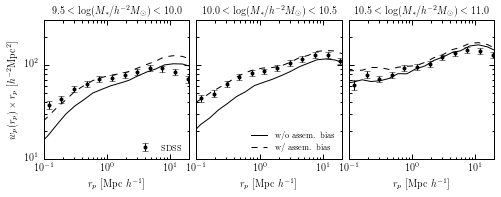

In [54]:
#load SDSS results from Yang 2012
from lss_observations import yang_2012_wp

#create arrays to store results

wp_sdss_1, cov = yang_2012_wp(10.0**9.5,10.0**10.0, sample='Mass-limit')
err_1 = np.sqrt(np.diagonal(cov))

wp_sdss_2, cov = yang_2012_wp(10.0**10.0,10.0**10.5, sample='Mass-limit')
err_2 = np.sqrt(np.diagonal(cov))

wp_sdss_3, cov = yang_2012_wp(10.0**10.5,10.0**11.0, sample='Mass-limit')
err_3 = np.sqrt(np.diagonal(cov))

fig1, axes = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(6.95, 2.75))
fig1.subplots_adjust(hspace=0, wspace=0.05, left=0.075, right=0.975, bottom=0.2, top=0.9)
    
ax = axes[0]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$w_p(r_p)\times r_p ~ [h^{-2}{\rm Mpc}^2]$')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$9.5<\log(M_{*}/h^{-2}M_{\odot})<10.0$')
    
ax = axes[1]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$10.0<\log(M_{*}/h^{-2}M_{\odot})<10.5$')
    
ax = axes[2]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$10.5<\log(M_{*}/h^{-2}M_{\odot})<11.0$')

ax = axes[0]
p1, = ax.plot(rp_bin_centers, wp_a[0]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[0]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_1[0,:], wp_sdss_1[1,:]*wp_sdss_1[0,:], yerr=err_1*wp_sdss_1[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[1]
p1, = ax.plot(rp_bin_centers, wp_a[1]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[1]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_2[0,:], wp_sdss_2[1,:]*wp_sdss_2[0,:], yerr=err_2*wp_sdss_2[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[2]
p1, = ax.plot(rp_bin_centers, wp_a[2]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[2]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_3[0,:], wp_sdss_3[1,:]*wp_sdss_3[0,:], yerr=err_3*wp_sdss_3[0,:],
                  fmt='o', color='black', ms=4, mec='none')

#add legends
ax = axes[1]
ax.legend((p2,p1),
     ('w/o assem. bias','w/ assem. bias'),
     frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)


ax = axes[0]
ax.legend([p0],
    (['SDSS']),
    frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)

plt.show()

filepath = './plots/'
filename = 'wp_comparison_assem_bias'
fig1.savefig(filepath+filename+'.pdf', dpi=300)

###model w/ assembly bias

In [9]:
from beyond_age_matching.make_mocks.model_components import MosterSmHm13AssemBias

#build model
prim_haloprop_key = 'halo_mpeak'
sec_haloprop_key = 'halo_half_mass_scale'
mstar_model = MosterSmHm13AssemBias(prim_haloprop_key = prim_haloprop_key,
                                    sec_haloprop_key=sec_haloprop_key, redshift=0.0,
                                    scatter_abscissa=scatter_abscissa,
                                    scatter_ordinates=scatter_ordinates,
                                    assem_scatter_abscissa=assem_scatter_abscissa,
                                    assem_scatter_ordinates=assem_scatter_ordinates)
#mstar_model.param_dict['scatter_model_param1'] =  0.18
#mstar_model.param_dict['assem_bias_sigma'] =  0.0
#mstar_model.param_dict['gamma10'] = 0.708
#mstar_model.param_dict['m10'] = 11.590

composite_model_a = SubhaloModelFactory(stellar_mass = mstar_model,
                                       galaxy_selection_func = galaxy_selection_func)

#populate simulation
composite_model_a.populate_mock(halocat = halocat)
mock_a = composite_model_a.mock.galaxy_table
mock_a['stellar_mass'] = mock_a['stellar_mass']*0.85

print("number of galaxies in mock: ", len(mock_a))
f_sat = float(np.sum(mock_a['halo_upid']!=-1))/len(mock_a)
print("satellite fraction: ", f_sat)

number of galaxies in mock:  313953
satellite fraction:  0.262278111692


###model w/o assembly bias

In [10]:
assem_scatter_ordinates_b = np.zeros(len(assem_scatter_abscissa))+100.0

#build model
prim_haloprop_key = 'halo_mpeak'
sec_haloprop_key = 'halo_half_mass_scale'
mstar_model = MosterSmHm13AssemBias(prim_haloprop_key = prim_haloprop_key,
                                    sec_haloprop_key=sec_haloprop_key, redshift=0.0,
                                    scatter_abscissa=scatter_abscissa,
                                    scatter_ordinates=scatter_ordinates,
                                    assem_scatter_abscissa=assem_scatter_abscissa,
                                    assem_scatter_ordinates=assem_scatter_ordinates_b)
#mstar_model.param_dict['scatter_model_param1'] =  0.18
#mstar_model.param_dict['assem_bias_sigma'] =  0.0
#mstar_model.param_dict['gamma10'] = 0.708
#mstar_model.param_dict['m10'] = 11.590

composite_model_b = SubhaloModelFactory(stellar_mass = mstar_model,
                                      galaxy_selection_func = galaxy_selection_func)

#populate simulation
composite_model_b.populate_mock(halocat = halocat)
mock_b = composite_model_b.mock.galaxy_table
mock_b['stellar_mass'] = mock_b['stellar_mass']*0.85

print("number of galaxies in mock: ", len(mock_b))
f_sat = float(np.sum(mock_b['halo_upid']!=-1))/len(mock_b)
print("satellite fraction: ", f_sat)

number of galaxies in mock:  314226
satellite fraction:  0.21599422072


##The SMHM Relation

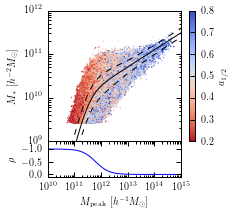

In [11]:
from scipy.interpolate import interp1d
x = np.log10(scatter_abscissa)
y = scatter_ordinates
f = interp1d(x,y)

fig = plt.figure(figsize=(3.3,3.3))

rect = 0.2,0.35,0.7,0.55
ax = fig.add_axes(rect)
#fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.scatter(mock_a['halo_mpeak'], mock_a['stellar_mass'], c = mock_a['halo_half_mass_scale'],
            lw=0, s=2, vmin=0.2, vmax=0.8, cmap='coolwarm_r', rasterized=True)
msample = np.logspace(10,15,100)
ax.plot(msample, 10**(np.log10(composite_model_a.mean_stellar_mass(prim_haloprop = msample, halo_acc_scale=1.0)) + f(np.log10(msample))), '--', color='black')
ax.plot(msample, composite_model_a.mean_stellar_mass(prim_haloprop = msample, halo_acc_scale=1.0), color='black')
ax.plot(msample, 10**(np.log10(composite_model_a.mean_stellar_mass(prim_haloprop = msample, halo_acc_scale=1.0)) - f(np.log10(msample))), '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**10,10**15])
ax.set_ylim([10**9,10**12])
ax.xaxis.set_visible(False)
#plt.xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_ylabel(r'$M_{*} ~ [h^{-2}M_{\odot}]$')
cbar = plt.colorbar()
cbar.set_label(r'$a_{1/2}$')
cbar.set_ticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8])

rect = 0.2,0.2,0.562,0.15
ax = fig.add_axes(rect)
ax.plot(assem_scatter_abscissa, assem_rho_ordinates)
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_ylim([0.1,-1.3])
ax.set_yticks([0,-0.5, -1])
ax.set_ylabel(r'$\rho$')


plt.show()

filepath = './plots/'
filename = 'smhm_assem_bias'
fig.savefig(filepath+filename+'.pdf', dpi=300)

##z=0 Galaxy Clustering

In [12]:
#set up function to calculate projected correlation function
#in stellar mass bins after placing mock in redshift-space.

from halotools.mock_observables import wp, return_xyz_formatted_array

def calculate_wp(mock, rp_bins,
                 log_mstar_min=10.0, log_mstar_max =10.5,
                 pi_max=40.0, Lbox=250.0):
    """
    Calculate the projected correaltion function
    """
    
    #number of threads to use in wp calculation
    num_threads = 4
    
    #create mask for stellar mass bin
    mask = (mock['stellar_mass']<10.0**log_mstar_max) &\
           (mock['stellar_mass']>10.0**log_mstar_min)
    
    #put galaxy coordinates in mock observables format
    #and apply redshift space distortions
    coords = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'],
                                        velocity = mock['vz'],
                                        velocity_distortion_dimension = 'z',
                                        period = Lbox)
    
    #apply mask for stellar mass bin
    coords = coords[mask]
    
    result = wp(coords,
                rp_bins = rp_bins, pi_max = pi_max,
                period = Lbox,
                do_auto = True, do_cross = False,
                estimator = 'Natural', 
                num_threads = num_threads,
                max_sample_size = int(1e7))
        
    return result

In [13]:
#examine clustering

#calculate wp for each model in stellar mass bins

#define rp bins
rp_bins = np.logspace(-2.0,1.4,25)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/2.0

#create arrays to store results for each mock
wp_a = np.zeros((3,24))
wp_b = np.zeros((3,24))

wp_a[0] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)
wp_a[1] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)
wp_a[2] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)

wp_b[0] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)
wp_b[1] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)
wp_b[2] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)

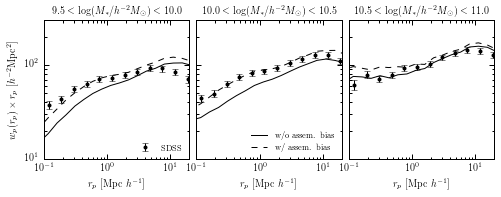

In [14]:
#load SDSS results from Yang 2012
from lss_observations import yang_2012_wp

#create arrays to store results

wp_sdss_1, cov = yang_2012_wp(10.0**9.5,10.0**10.0, sample='Mass-limit')
err_1 = np.sqrt(np.diagonal(cov))

wp_sdss_2, cov = yang_2012_wp(10.0**10.0,10.0**10.5, sample='Mass-limit')
err_2 = np.sqrt(np.diagonal(cov))

wp_sdss_3, cov = yang_2012_wp(10.0**10.5,10.0**11.0, sample='Mass-limit')
err_3 = np.sqrt(np.diagonal(cov))

fig1, axes = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(6.95, 2.75))
fig1.subplots_adjust(hspace=0, wspace=0.05, left=0.075, right=0.975, bottom=0.2, top=0.9)
    
ax = axes[0]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$w_p(r_p)\times r_p ~ [h^{-2}{\rm Mpc}^2]$')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$9.5<\log(M_{*}/h^{-2}M_{\odot})<10.0$')
    
ax = axes[1]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$10.0<\log(M_{*}/h^{-2}M_{\odot})<10.5$')
    
ax = axes[2]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$10.5<\log(M_{*}/h^{-2}M_{\odot})<11.0$')

ax = axes[0]
p1, = ax.plot(rp_bin_centers, wp_a[0]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[0]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_1[0,:], wp_sdss_1[1,:]*wp_sdss_1[0,:], yerr=err_1*wp_sdss_1[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[1]
p1, = ax.plot(rp_bin_centers, wp_a[1]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[1]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_2[0,:], wp_sdss_2[1,:]*wp_sdss_2[0,:], yerr=err_2*wp_sdss_2[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[2]
p1, = ax.plot(rp_bin_centers, wp_a[2]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[2]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_3[0,:], wp_sdss_3[1,:]*wp_sdss_3[0,:], yerr=err_3*wp_sdss_3[0,:],
                  fmt='o', color='black', ms=4, mec='none')

#add legends
ax = axes[1]
ax.legend((p2,p1),
     ('w/o assem. bias','w/ assem. bias'),
     frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)


ax = axes[0]
ax.legend([p0],
    (['SDSS']),
    frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)

plt.show()

##Define CAM Model #2

model that includes evolution of the SMHM relation

In [15]:
from halotools.empirical_models import SubhaloModelFactory

#define galaxy selection
def galaxy_selection_func(table):
    mask = (table['stellar_mass'] >= 10**9.5)
    return mask

In [4]:
#add halo properties
halocat.halo_table['halo_0.1_mpeak_prime_scale'] = add_halo_props['halo_0.1_mpeak_prime_scale']
halocat.halo_table['halo_0.2_mpeak_prime_scale'] = add_halo_props['halo_0.2_mpeak_prime_scale']
halocat.halo_table['halo_0.3_mpeak_prime_scale'] = add_halo_props['halo_0.3_mpeak_prime_scale']
halocat.halo_table['halo_0.4_mpeak_prime_scale'] = add_halo_props['halo_0.4_mpeak_prime_scale']
halocat.halo_table['halo_0.5_mpeak_prime_scale'] = add_halo_props['halo_0.5_mpeak_prime_scale']
halocat.halo_table['halo_0.6_mpeak_prime_scale'] = add_halo_props['halo_0.6_mpeak_prime_scale']
halocat.halo_table['halo_0.7_mpeak_prime_scale'] = add_halo_props['halo_0.7_mpeak_prime_scale']
halocat.halo_table['halo_0.8_mpeak_prime_scale'] = add_halo_props['halo_0.8_mpeak_prime_scale']
halocat.halo_table['halo_0.9_mpeak_prime_scale'] = add_halo_props['halo_0.9_mpeak_prime_scale']

In [5]:
#define cosmolgy functions
import cosmolopy.perturbation as pb
from hmf import hmf
from scipy.interpolate import interp1d

h = hmf.MassFunction(Mmin=9, Mmax=16, z=0.0)

def sigma(m):
    """
    """
    x = h.m
    y = h.sigma
    f = interp1d(np.log10(x),y, kind='linear', fill_value='extrapolate')
    return f(np.log10(m))
    
def D(z):
    """
    """
    result = pb.fgrowth(z,cosmo.Om0)
    return result

def delta_c(z):
    """
    """
    result =  1.686/D(z)
    return result

def G(z,M,z0,M0):
    """
    """
    result =  0.57 * (((sigma(M)**2.0)/(sigma(M0)**2.0))**(0.19))*(delta_c(z0)/sigma(M0))**(-0.01)
    return result

def w(z,M,M0,z0):
    """
    """
    result =  (delta_c(z) - delta_c(z0))/np.sqrt(sigma(M)**2.0-sigma(M0)**2.0)
    return result

def tilde_w(z,M,M0,z0):
    """
    """
    gamma = 0.4
    result =  w(z,M,M0,z0)*(G(z,M,z0,M0)**gamma)
    return result

In [6]:
z0 = 1.0/halocat.halo_table['halo_first_acc_scale']-1.0
M0 = halocat.halo_table['halo_mpeak']

f = 0.1
z1 = 1.0/halocat.halo_table['halo_0.1_mpeak_prime_scale']-1.0
w_01 = w(z1,f*M0,M0,z0)

f = 0.2
z1 = 1.0/halocat.halo_table['halo_0.2_mpeak_prime_scale']-1.0
w_02 = w(z1,f*M0,M0,z0)

f = 0.3
z1 = 1.0/halocat.halo_table['halo_0.3_mpeak_prime_scale']-1.0
w_03 = w(z1,f*M0,M0,z0)

f = 0.4
z1 = 1.0/halocat.halo_table['halo_0.4_mpeak_prime_scale']-1.0
w_04 = w(z1,f*M0,M0,z0)

f = 0.5
z1 = 1.0/halocat.halo_table['halo_0.5_mpeak_prime_scale']-1.0
w_05 = w(z1,f*M0,M0,z0)

f = 0.6
z1 = 1.0/halocat.halo_table['halo_0.6_mpeak_prime_scale']-1.0
w_06 = w(z1,f*M0,M0,z0)

f = 0.7
z1 = 1.0/halocat.halo_table['halo_0.7_mpeak_prime_scale']-1.0
w_07 = w(z1,f*M0,M0,z0)

f = 0.8
z1 = 1.0/halocat.halo_table['halo_0.8_mpeak_prime_scale']-1.0
w_08 = w(z1,f*M0,M0,z0)

f = 0.9
z1 = 1.0/halocat.halo_table['halo_0.9_mpeak_prime_scale']-1.0
w_09 = w(z1,f*M0,M0,z0)

0.198349997401
0.713097680072


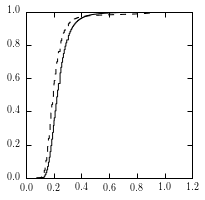

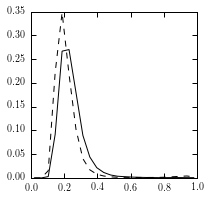

In [26]:
host = (halocat.halo_table['halo_upid']==-1)
sub = (halocat.halo_table['halo_upid']!=-1)

bins = np.linspace(0,1,25)
bin_centers = (bins[:-1]+bins[1:])/2.0
from scipy.interpolate import interp1d

cdf_host = 1.0*np.cumsum(np.ones(np.sum(host)))/np.sum(host)
pdf_host = np.histogram(halocat.halo_table['halo_0.1_mpeak_prime_scale'][host], bins=bins)[0]/np.sum(host)
w_host = np.sort(halocat.halo_table['halo_0.1_mpeak_prime_scale'][host])
f_host = interp1d(w_host, cdf_host)

cdf_sub = 1.0*np.cumsum(np.ones(np.sum(sub)))/np.sum(sub)
pdf_sub = np.histogram(halocat.halo_table['halo_0.1_mpeak_prime_scale'][sub], bins=bins)[0]/np.sum(sub)
w_sub = np.sort(halocat.halo_table['halo_0.1_mpeak_prime_scale'][sub])
f_sub = interp1d(cdf_sub, w_sub)

w_mean_sub = f_sub(0.5)
print(w_mean_sub)
print(1.0 - f_host(w_mean_sub))

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(w_host, cdf_host, '-', color='black')
plt.plot(w_sub, cdf_sub, '--', color='black')
plt.show()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(bin_centers, pdf_host, '-', color='black')
plt.plot(bin_centers, pdf_sub, '--', color='black')
plt.show()

In [28]:
from scipy.interpolate import interp1d

def mean_sub_p(f=0.5):
    
    bins = np.linspace(0,1,25)
    bin_centers = (bins[:-1]+bins[1:])/2.0

    cdf_host = 1.0*np.cumsum(np.ones(np.sum(host)))/np.sum(host)
    pdf_host = np.histogram(halocat.halo_table['halo_'+str(f)+'_mpeak_prime_scale'][host], bins=bins)[0]/np.sum(host)
    w_host = np.sort(halocat.halo_table['halo_'+str(f)+'_mpeak_prime_scale'][host])
    f_host = interp1d(w_host, cdf_host)

    cdf_sub = 1.0*np.cumsum(np.ones(np.sum(sub)))/np.sum(sub)
    pdf_sub = np.histogram(halocat.halo_table['halo_'+str(f)+'_mpeak_prime_scale'][sub], bins=bins)[0]/np.sum(sub)
    w_sub = np.sort(halocat.halo_table['halo_'+str(f)+'_mpeak_prime_scale'][sub])
    f_sub = interp1d(cdf_sub, w_sub)

    w_mean_sub = f_sub(0.5)
    print(w_mean_sub)
    return 1.0 - f_host(w_mean_sub)

In [30]:
fs = np.arange(0.1,1.0,0.1)
p1 = mean_sub_p(0.1)
p2 = mean_sub_p(0.2)
p3 = mean_sub_p(0.3)
p4 = mean_sub_p(0.4)
p5 = mean_sub_p(0.5)
p6 = mean_sub_p(0.6)
p7 = mean_sub_p(0.7)
p8 = mean_sub_p(0.8)
p9 = mean_sub_p(0.9)

0.198349997401
0.228349998593
0.258350014687
0.288349986076
0.318349987268
0.35435000062
0.390350013971
0.43235000968
0.498349994421


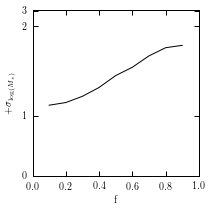

In [49]:
fs = np.arange(0.1,1.0,0.1)
ps = np.array([p1,p2,p3,p4,p5,p6,p7,p8,p9])

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(fs, ps, '-', color='black')
plt.ylim([0.5,1])
plt.xlim([0,1])
plt.yticks([0.5,0.68, 0.95, 0.997])
ax.set_yticklabels([0,1,2,3])
plt.ylabel(r'$+\sigma_{\log(M_*)}$')
plt.xlabel(r'${\rm f}$')
plt.show()

In [53]:
from scipy.stats import norm

10**1.2/10**1

1.5848931924611134

In [62]:
#calculate percentiles based on w_f in mass bins
min_mpeak = np.log10(halocat.particle_mass * 50.0) + 0.1
mass_bins = 10**np.arange(min_mpeak,14.4,0.2)
mass_bin_centers = (mass_bins[:-1]+mass_bins[1:])/2.0

host = (halocat.halo_table['halo_first_acc_scale']>=1.0) & (halocat.halo_table['halo_upid']==-1.0)
sub = (host==False)

from scipy.stats import rankdata

inds = np.digitize(halocat.halo_table['halo_mpeak'], bins=mass_bins)

sign = 1.0

p_01 = np.zeros(len(w_01))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_01[mask & host])
    w = np.sort(w_01[mask & host])
    
    ii = unsorting_indices(temp)
    (p_01[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_01[mask & sub])
    temp[temp == N] = N-1
    p_01[mask & sub] = p[temp]

p_02 = np.zeros(len(w_02))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_02[mask & host])
    w = np.sort(w_02[mask & host])
    
    ii = unsorting_indices(temp)
    (p_02[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_02[mask & sub])
    temp[temp == N] = N-1
    p_02[mask & sub] = p[temp]
    
p_03 = np.zeros(len(w_03))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_03[mask & host])
    w = np.sort(w_03[mask & host])
    
    ii = unsorting_indices(temp)
    (p_03[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_03[mask & sub])
    temp[temp == N] = N-1
    p_03[mask & sub] = p[temp]

p_04 = np.zeros(len(w_04))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_04[mask & host])
    w = np.sort(w_04[mask & host])
    
    ii = unsorting_indices(temp)
    (p_04[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_04[mask & sub])
    temp[temp == N] = N-1
    p_04[mask & sub] = p[temp]

p_05 = np.zeros(len(w_05))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_05[mask & host])
    w = np.sort(w_05[mask & host])
    
    ii = unsorting_indices(temp)
    (p_05[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_05[mask & sub])
    temp[temp == N] = N-1
    p_05[mask & sub] = p[temp]

p_06 = np.zeros(len(w_06))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_06[mask & host])
    w = np.sort(w_06[mask & host])
    
    ii = unsorting_indices(temp)
    (p_06[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_06[mask & sub])
    temp[temp == N] = N-1
    p_06[mask & sub] = p[temp]
    
p_07 = np.zeros(len(w_07))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_07[mask & host])
    w = np.sort(w_07[mask & host])
    
    ii = unsorting_indices(temp)
    (p_07[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_07[mask & sub])
    temp[temp == N] = N-1
    p_07[mask & sub] = p[temp]

p_08 = np.zeros(len(w_08))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_08[mask & host])
    w = np.sort(w_08[mask & host])
    
    ii = unsorting_indices(temp)
    (p_08[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_08[mask & sub])
    temp[temp == N] = N-1
    p_08[mask & sub] = p[temp]

p_09 = np.zeros(len(w_09))
for i in range(0,len(mass_bins)):
    mask = (inds==i)
    
    #hosts
    N = np.sum(mask & host)
    p = np.sort(np.random.random(N))
    
    temp = np.argsort(w_09[mask & host])
    w = np.sort(w_09[mask & host])
    
    ii = unsorting_indices(temp)
    (p_09[mask & host]) = p[ii]
    
    #subs
    temp = np.searchsorted(w, w_09[mask & sub])
    temp[temp == N] = N-1
    p_09[mask & sub] = p[temp]

In [63]:
halocat.halo_table['p_01'] = p_01
halocat.halo_table['p_02'] = p_02
halocat.halo_table['p_03'] = p_03
halocat.halo_table['p_04'] = p_04
halocat.halo_table['p_05'] = p_05
halocat.halo_table['p_06'] = p_06
halocat.halo_table['p_07'] = p_07
halocat.halo_table['p_08'] = p_08
halocat.halo_table['p_09'] = p_09

In [29]:
halocat.halo_table['p_dens'] = add_halo_props['p']
halocat.halo_table['p_0'] = np.random.random(len(halocat.halo_table))

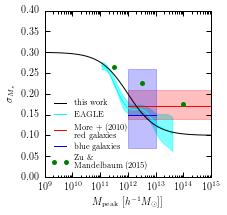

In [23]:
scatter_abscissa  = np.arange(9,17,0.1)

from scipy.stats import norm
scatter_ordinates = norm.cdf(scatter_abscissa[::-1], loc=13.5, scale=1.0)*0.15 + 0.15
scatter_abscissa = 10**scatter_abscissa

#define model for scatter
def f_sigma(m, m0=12.0, k=2.0, sigma0=0.1, sigma1=0.3):
    x = np.log10(m)
    return (sigma1-sigma0)/(1.0+np.exp(1.0*k*(x-m0))) + sigma0
    
#literature measurements of the scatter
#EAGLE
m1 = np.array([13.5985, 13.5190, 13.4198,13.3166,13.2054,13.0863,12.9871,
               12.9036,12.8043,12.7169,12.6177,12.5025,12.3835,12.2922,
               12.1494,12.0184,11.9350,11.8396,11.7761,11.7085,11.6449,
               11.5614,11.5018,11.4144,11.3468,11.2792,11.2117,11.1283,11.0529])
s1 = np.array([0.102731,0.109166,0.112370,0.114498,0.118238,0.122513,
               0.128406,0.135377,0.143958,0.151466,0.158434,0.162173,
               0.162685,0.161590,0.161560,0.165295,0.170116,0.178697,
               0.185673,0.194798,0.203924,0.215197,0.225399,0.237208,
               0.246871,0.254384,0.261358,0.266717,0.267238])
m11 = np.array([13.6020,13.5067,13.4114,13.3003,13.1892,13.0582,12.9510,
                12.8438,12.7446,12.6254,12.5262,12.4111,12.3119,12.2127,
                12.0738,11.9706,11.8514,11.7640,11.6646,11.5811,11.4818,
                11.4102,11.3268,11.2473,11.1480,11.0488])
s11 = np.array([0.143592,0.148948,0.151616,0.151054,0.151030,0.151540,
                0.154743,0.161171,0.165989,0.170802,0.173469,0.173981,
                0.172347,0.172864,0.176059,0.181951,0.192141,0.201262,
                0.213606,0.226491,0.239911,0.249035,0.259770,0.267818,
                0.274248,0.276377])
m12 = np.array([13.6029,13.5036,13.3845,13.2773,13.1463,13.0191,12.8999,
                12.8006,12.7131,12.6337,12.5384,12.4550,12.3400,12.2011,
                12.0979,11.9629,11.8597,11.7405,11.6252,11.5258,11.4463,
                11.3588,11.2555,11.1761,11.0927,11.0570])
s12 = np.array([0.0618715,0.0693771,0.0741902,0.0800812,0.0875799,0.0993806,
                0.114409,0.126753,0.137487,0.144459,0.149815,0.152485,
                0.150848,0.149205,0.149183,0.154530,0.162035,0.175450,
                0.192630,0.208738,0.221086,0.236659,0.247389,0.254899,
                0.258645,0.258637])

#More
m3r = np.array([12,15])
s3r = np.array([0.17,0.17])
s3r_upper =  s3r + 0.04
s3r_lower =  s3r - 0.03
m3b = np.array([12,13])
s3b = np.array([0.15,0.15])
s3b_upper =  s3b + 0.11
s3b_lower =  s3b - 0.08

#Zu and Mandlebaum
m4 = np.array([11.5,12.5,14.0])
s4 = np.array([10.18-9.65,10.8-10.35,11.389-11.04])/2.0

#plot model and literature values
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.fill_between(10**m11, s12, s11, color='cyan', alpha=0.5)
p1, = plt.plot(10**m1, s1, color='cyan')
plt.fill_between(10**m3r, s3r_lower, s3r_upper, color='red', alpha=0.25)
p3a, = plt.plot(10**m3r, s3r, color='red')
plt.fill_between(10**m3b, s3b_lower, s3b_upper, color='blue', alpha=0.25)
p3b, = plt.plot(10**m3b, s3b, color='blue')
p2, = plt.plot(10**m4, s4, 'o', color='green', mec='none', ms=5)
p0, = plt.plot(scatter_abscissa, f_sigma(scatter_abscissa), '-', color='black')
plt.xscale('log')
plt.xlim([10**9,10**15])
plt.ylim([0,0.4])
plt.ylabel(r'$\sigma_{M_*}$')
plt.xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]]$')
plt.legend((p0,p1,p3a,p3b,p2),('this work','EAGLE','More + (2010)\n red galaxies','blue galaxies','Zu \&\n Mandelbaum (2015)'),frameon = False, fontsize=8, loc='lower left')
plt.show()

filepath = './plots/'
filename = 'scatter_model'
fig.savefig(filepath+filename+'.pdf', dpi=300)

scatter_ordinates = f_sigma(scatter_abscissa)

In [53]:
from halotools.empirical_models import SubhaloModelFactory

#define galaxy selection
def galaxy_selection_func(table):
    mask = (table['stellar_mass'] >= 10**9.5) & (table['stellar_mass'] != np.inf)
    return mask

from beyond_age_matching.make_mocks.model_components import HaloProps
additional_halo_properties = HaloProps(['halo_mpeak','halo_vpeak','halo_half_mass_scale','halo_first_acc_scale'])

from beyond_age_matching.make_mocks.model_components import MosterSmHm13AssemBias_new as MosterSmHm13AssemBias

prim_haloprop_key = 'halo_mpeak'
sec_haloprop_key = 'p_dens'
mstar_model = MosterSmHm13AssemBias(prim_haloprop_key = prim_haloprop_key,
                                    sec_haloprop_key = sec_haloprop_key, redshift=0.0,
                                    scatter_abscissa = scatter_abscissa,
                                    scatter_ordinates = scatter_ordinates)
mstar_model.littleh = 0.701
mstar_model._m_conv_factor = 0.8


composite_model = SubhaloModelFactory(stellar_mass = mstar_model,
                                      haloprops = additional_halo_properties,
                                      galaxy_selection_func = galaxy_selection_func)

#composite_model.param_dict['scatter_model_param1'] =  0.18
composite_model.param_dict['m10'] = 11.590
composite_model.param_dict['m11'] = 1.195
composite_model.param_dict['n10'] = 0.0351
composite_model.param_dict['n11'] = -0.0247
composite_model.param_dict['beta10'] = 1.376
composite_model.param_dict['beta11'] = -0.826
composite_model.param_dict['gamma10'] = 0.608
composite_model.param_dict['gamma11'] = 0.329


#populate simulation
composite_model.populate_mock(halocat = halocat)
mock_a = composite_model.mock.galaxy_table
#mock_a['stellar_mass'] = mock_a['stellar_mass']

print("number of galaxies in mock: ", len(mock_a))
f_sat = float(np.sum(mock_a['halo_upid']!=-1))/len(mock_a)
print("satellite fraction: ", f_sat)

number of galaxies in mock:  295995
satellite fraction:  0.193787057214


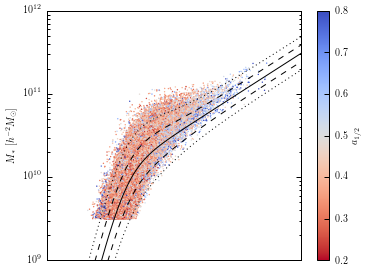

In [55]:
fig = plt.figure(figsize=(6.3,6.3))

sat = (mock_a['halo_upid']!=-1)
cen = (mock_a['halo_upid']==-1)

from scipy.interpolate import interp1d
x = np.log10(scatter_abscissa)
y = scatter_ordinates
f = interp1d(x,y)

rect = 0.2,0.35,0.7,0.55
ax = fig.add_axes(rect)
#fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.scatter(mock_a['halo_mpeak'][sat], mock_a['stellar_mass'][sat], c = mock_a['halo_half_mass_scale'][sat],
            lw=0, s=2, vmin=0.2, vmax=0.8, cmap='coolwarm_r', rasterized=True)
#plt.scatter(mock_a['halo_mpeak'][cen], mock_a['stellar_mass'][cen], c = mock_a['halo_half_mass_scale'][cen],
#            lw=0, s=2, vmin=0.2, vmax=0.8, cmap='coolwarm_r', rasterized=True)
msample = np.logspace(10,15,100)
ax.plot(msample, 10**(np.log10(composite_model.mean_stellar_mass(prim_haloprop = msample, halo_first_acc_scale=1.0)) + 2.0*f(np.log10(msample))), ':', color='black')
ax.plot(msample, 10**(np.log10(composite_model.mean_stellar_mass(prim_haloprop = msample, halo_first_acc_scale=1.0)) + f(np.log10(msample))), '--', color='black')
ax.plot(msample, composite_model.mean_stellar_mass(prim_haloprop = msample, halo_first_acc_scale=1.0), color='black')
ax.plot(msample, 10**(np.log10(composite_model.mean_stellar_mass(prim_haloprop = msample, halo_first_acc_scale=1.0)) - f(np.log10(msample))), '--', color='black')
ax.plot(msample, 10**(np.log10(composite_model.mean_stellar_mass(prim_haloprop = msample, halo_first_acc_scale=1.0)) - 2.0*f(np.log10(msample))), ':', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**10,10**15])
ax.set_ylim([10**9,10**12])
ax.xaxis.set_visible(False)
#plt.xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_ylabel(r'$M_{*} ~ [h^{-2}M_{\odot}]$')
cbar = plt.colorbar()
cbar.set_label(r'$a_{1/2}$')
cbar.set_ticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8])

plt.show()

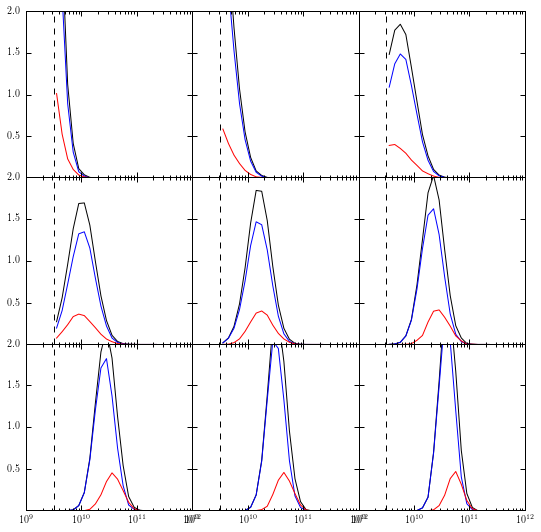

In [58]:
mass_bins = np.arange(11.0,15,0.2)
mass_bins = 10.0**mass_bins
mass_bin_centers = (mass_bins[:-1]+mass_bins[1:])/2.0

inds = np.digitize(mock_a['halo_mpeak'], bins = mass_bins)

mstar_bins = np.arange(9.5,11.5,0.1)
dlogmstar = np.diff(mstar_bins)
mstar_bins = 10.0**mstar_bins
dmstar = np.diff(mstar_bins)
mstar_bin_centers = (mstar_bins[:-1]+mstar_bins[1:])/2.0

Nbins1 = len(mass_bin_centers)
Nbins2 = len(mstar_bin_centers)
p_1 = np.zeros((Nbins1, Nbins2))
p_2 = np.zeros((Nbins1, Nbins2))
p_3 = np.zeros((Nbins1, Nbins2))
for i in range(1,len(mass_bin_centers)):
    mask = (inds==i)
    N = np.sum(mask)
    counts_1 = np.histogram(mock_a['stellar_mass'][mask], bins=mstar_bins)[0]
    p_1[i-1,:] = 1.0*counts_1/N/dlogmstar
    counts_2 = np.histogram(mock_a['stellar_mass'][mask & cen], bins=mstar_bins)[0]
    p_2[i-1,:]  = 1.0*counts_2/N/dlogmstar
    counts_3 = np.histogram(mock_a['stellar_mass'][mask & sat], bins=mstar_bins)[0]
    p_3[i-1,:]  = 1.0*counts_3/N/dlogmstar

fig, axes = plt.subplots(nrows=3,ncols=3,sharex=True, sharey=True,figsize=(9.9,9.9))
axes = axes.flatten()
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9, wspace=0.0, hspace=0.0)
for i in range(0,9):
    ax = axes[i]
    ax.plot([10**9.5,10**9.5],[0.0001,10],'--', color='black')
    ax.plot(mstar_bin_centers, p_1[i,:], color='black')
    ax.plot(mstar_bin_centers, p_2[i,:], color='blue')
    ax.plot(mstar_bin_centers, p_3[i,:], color='red')
plt.xscale('log')
#plt.yscale('log')
plt.ylim([0.01,2])
plt.show()

In [30]:
from halotools.empirical_models import SubhaloModelFactory

#define galaxy selection
def galaxy_selection_func(table):
    mask = (table['stellar_mass'] >= 10**9.5)
    return mask

from beyond_age_matching.make_mocks.model_components import HaloProps
additional_halo_properties = HaloProps(['halo_mpeak','halo_vpeak','halo_half_mass_scale','halo_first_acc_scale'])

from beyond_age_matching.make_mocks.model_components import MosterSmHm13AssemBias_new as MosterSmHm13AssemBias

prim_haloprop_key = 'halo_mpeak'
sec_haloprop_key = 'p_0'
mstar_model = MosterSmHm13AssemBias(prim_haloprop_key = prim_haloprop_key,
                                    sec_haloprop_key = sec_haloprop_key, redshift=0.0,
                                    scatter_abscissa = scatter_abscissa,
                                    scatter_ordinates = scatter_ordinates)
mstar_model.littleh = 0.701
mstar_model._m_conv_factor = 0.8


composite_model = SubhaloModelFactory(stellar_mass = mstar_model,
                                      haloprops = additional_halo_properties,
                                      galaxy_selection_func = galaxy_selection_func)

#composite_model.param_dict['scatter_model_param1'] =  0.18
composite_model.param_dict['m10'] = 11.590
composite_model.param_dict['m11'] = 1.195
composite_model.param_dict['n10'] = 0.0351
composite_model.param_dict['n11'] = -0.0247
composite_model.param_dict['beta10'] = 1.376
composite_model.param_dict['beta11'] = -0.826
composite_model.param_dict['gamma10'] = 0.608
composite_model.param_dict['gamma11'] = 0.329


#populate simulation
composite_model.populate_mock(halocat = halocat)
mock_b = composite_model.mock.galaxy_table
mock_b['stellar_mass'] = mock_b['stellar_mass']

print("number of galaxies in mock: ", len(mock_b))
f_sat = float(np.sum(mock_b['halo_upid']!=-1))/len(mock_b)
print("satellite fraction: ", f_sat)

number of galaxies in mock:  288416
satellite fraction:  0.161208116055


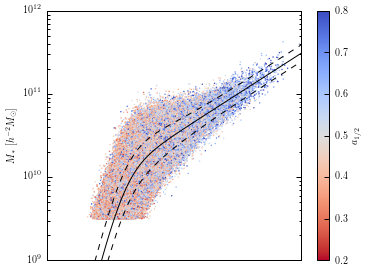

In [31]:
fig = plt.figure(figsize=(6.3,6.3))

sat = (mock_b['halo_upid']!=-1)
cen = (mock_b['halo_upid']==-1)

from scipy.interpolate import interp1d
x = np.log10(scatter_abscissa)
y = scatter_ordinates
f = interp1d(x,y)

rect = 0.2,0.35,0.7,0.55
ax = fig.add_axes(rect)
#fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.scatter(mock_b['halo_mpeak'][sat], mock_b['stellar_mass'][sat], c = mock_b['halo_half_mass_scale'][sat],
            lw=0, s=2, vmin=0.2, vmax=0.8, cmap='coolwarm_r', rasterized=True)
plt.scatter(mock_b['halo_mpeak'][cen], mock_b['stellar_mass'][cen], c = mock_b['halo_half_mass_scale'][cen],
            lw=0, s=2, vmin=0.2, vmax=0.8, cmap='coolwarm_r', rasterized=True)
msample = np.logspace(10,15,100)
ax.plot(msample, 10**(np.log10(composite_model.mean_stellar_mass(prim_haloprop = msample, halo_first_acc_scale=1.0)) + f(np.log10(msample))), '--', color='black')
ax.plot(msample, composite_model.mean_stellar_mass(prim_haloprop = msample, halo_first_acc_scale=1.0), color='black')
ax.plot(msample, 10**(np.log10(composite_model.mean_stellar_mass(prim_haloprop = msample, halo_first_acc_scale=1.0)) - f(np.log10(msample))), '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**10,10**15])
ax.set_ylim([10**9,10**12])
ax.xaxis.set_visible(False)
#plt.xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_ylabel(r'$M_{*} ~ [h^{-2}M_{\odot}]$')
cbar = plt.colorbar()
cbar.set_label(r'$a_{1/2}$')
cbar.set_ticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8])

plt.show()

In [32]:
#examine clustering

#calculate wp for each model in stellar mass bins

#define rp bins
rp_bins = np.logspace(-2.0,1.4,25)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/2.0

#create arrays to store results for each mock
wp_a = np.zeros((3,24))
wp_b = np.zeros((3,24))

wp_a[0] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)
wp_a[1] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)
wp_a[2] = calculate_wp(mock_a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)

wp_b[0] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)
wp_b[1] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)
wp_b[2] = calculate_wp(mock_b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)

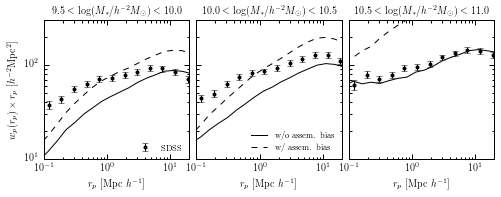

In [33]:
#load SDSS results from Yang 2012
from lss_observations import yang_2012_wp

#create arrays to store results

wp_sdss_1, cov = yang_2012_wp(10.0**9.5,10.0**10.0, sample='Mass-limit')
err_1 = np.sqrt(np.diagonal(cov))

wp_sdss_2, cov = yang_2012_wp(10.0**10.0,10.0**10.5, sample='Mass-limit')
err_2 = np.sqrt(np.diagonal(cov))

wp_sdss_3, cov = yang_2012_wp(10.0**10.5,10.0**11.0, sample='Mass-limit')
err_3 = np.sqrt(np.diagonal(cov))

fig1, axes = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(6.95, 2.75))
fig1.subplots_adjust(hspace=0, wspace=0.05, left=0.075, right=0.975, bottom=0.2, top=0.9)
    
ax = axes[0]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$w_p(r_p)\times r_p ~ [h^{-2}{\rm Mpc}^2]$')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$9.5<\log(M_{*}/h^{-2}M_{\odot})<10.0$')
    
ax = axes[1]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$10.0<\log(M_{*}/h^{-2}M_{\odot})<10.5$')
    
ax = axes[2]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[{\rm Mpc}~h^{-1}]$')
ax.set_title(r'$10.5<\log(M_{*}/h^{-2}M_{\odot})<11.0$')

ax = axes[0]
p1, = ax.plot(rp_bin_centers, wp_a[0]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[0]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_1[0,:], wp_sdss_1[1,:]*wp_sdss_1[0,:], yerr=err_1*wp_sdss_1[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[1]
p1, = ax.plot(rp_bin_centers, wp_a[1]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[1]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_2[0,:], wp_sdss_2[1,:]*wp_sdss_2[0,:], yerr=err_2*wp_sdss_2[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[2]
p1, = ax.plot(rp_bin_centers, wp_a[2]*rp_bin_centers, '--', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[2]*rp_bin_centers, '-', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_3[0,:], wp_sdss_3[1,:]*wp_sdss_3[0,:], yerr=err_3*wp_sdss_3[0,:],
                  fmt='o', color='black', ms=4, mec='none')

#add legends
ax = axes[1]
ax.legend((p2,p1),
     ('w/o assem. bias','w/ assem. bias'),
     frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)


ax = axes[0]
ax.legend([p0],
    (['SDSS']),
    frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)

plt.show()